# 지도학습-XGboost

In [1]:
from hossam import *

# 파이썬 기본 라이브러리
from pandas import DataFrame, concat, get_dummies, Series
import numpy as np
from itertools import combinations

# 시각화 라이브러리
from matplotlib import pyplot as plt
import seaborn as sb

# 통계 라이브러리
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset, het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from pingouin import anova, welch_anova
from scipy.stats import (
    normaltest,
    bartlett,
    levene,
    ttest_ind,
    pearsonr,
    spearmanr,
    shapiro,
    jarque_bera,
    t,
    f,
)

# 머신러닝 라이브러리
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve

# 학습모델
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
    SGDRegressor
)

# 성능 평가 지표 모듈
from sklearn.metrics import(
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error
)

# 확률적 경사 하강법
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance

# 랜덤포레스트
from sklearn.ensemble import RandomForestRegressor
import shap

# DecisionTree
from sklearn.tree import DecisionTreeRegressor
# BoostRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

# XGboost
from xgboost import XGBRegressor

def hs_get_scores(estimator, x_test, y_true):
    if hasattr(estimator, 'named_steps'):
        classname = estimator.named_steps['model'].__class__.__name__
    else:
        classname = estimator.__class__.__name__

    y_pred = estimator.predict(x_test)

    result_df = DataFrame(
        {
            '결정계수(R2)': r2_score(y_true, y_pred),
            '평균절대오차(MAE)': mean_absolute_error(y_true, y_pred),
            '평균제곱오차(MSE)': mean_squared_error(y_true, y_pred),
            '평균오차(RMSE)': np.sqrt(mean_squared_error(y_true, y_pred)),
            '평균 절대 백분오차 비율(MAPE)': mean_absolute_percentage_error(y_true,y_pred),
            '평균 비율 오차(MPE)': np.mean((y_true - y_pred) / y_true * 100)
        },
        index = [classname]
)

def hs_learning_cv(
        estimator,
        x,
        y,
        scoring ='neg_root_mean_squared_error',
        cv=5,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs = 1
):
    train_sizes, train_scores, cv_scores = learning_curve(
        estimator=estimator,
        X=x,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=52
    )

    model_name = estimator.named_steps['model'].__class__.__name__
    print(f'=== Learning Curve: {model_name}===')

    # neg RMSE -> RMSE
    train_rmse = -train_scores
    cv_rmse = -cv_scores

    # 평균 / 표준편차
    train_mean = train_rmse.mean(axis=1)
    cv_mean = cv_rmse.mean(axis=1)
    cv_std = cv_rmse.std(axis=1)

    # 마지막 지정 기준 정량 판정
    final_train = train_mean[-1]
    final_cv = cv_mean[-1]
    final_std = cv_std[-1]
    gap_ratio = final_train / final_cv
    var_ratio = final_std / final_cv
    
    # 과소적합 기준선 (some_threshold)
    # 기준모형 RMSE (평균예측)

    y_mean = y.mean()
    rmse_naive = np.sqrt(np.mean((y - y_mean) ** 2))

    # 분산 기반
    std_y = y.std()

    # 최소 설명력(R2)기반
    min_r2 = 0.10
    rmse_r2 = np.sqrt((1 - min_r2) * np.var(y))

    # 최종 threshold (가장 관대한 기준)
    # -> 원래 some_threshold는 도메인 지식 수준에서 이 모델은 최소 어느 정도의 성능은 내야 한다는 기준을 설정하는 것

    some_threshold = min(rmse_naive, std_y, rmse_r2)

    if gap_ratio >= 0.95 and final_cv > some_threshold:
        status = ('과소적합: bias 큼')
    elif gap_ratio <= 0.8:
        status = ('과대적합: variance 큼')
    elif gap_ratio <= 0.95 and var_ratio <= 0.10:
        status = ('일반화 양호')
    elif var_ratio > 0.15:
        status = ('데이터 부족: 분산 큼')
    else:
        status = ('판단 유보: 추가 지표 필요')

    # 정량 결과 표
    result_df = DataFrame({
        '지표': [
            'Train RMSE',
            'CV RMSE 평균',
            'CV RMSE 표준편차',
            'Train/CV 비율',
            'CV 변동성 비율',
            '판정 결과'
        ],
        '값':[
            final_train,
            final_cv,
            final_std,
            gap_ratio,
            var_ratio,
            status,
        ]
    })

    display(result_df)

    # 시각화

    figsize = (1200/my_dpi, 720/my_dpi)
    fig, ax = plt.subplots(1, 1, figsize = figsize, dpi = my_dpi)

    sb.lineplot(x = train_sizes, y = train_mean, marker = 'o', markeredgecolor = '#ffffff', label ='Train RMSE')
    sb.lineplot(x = train_sizes, y = cv_mean, marker = 'o', markeredgecolor = '#ffffff', label ='Train RMSE')


    ax.set_xlabel('RMSE', fontsize=8, labelpad=5)
    ax.set_ylabel('학습곡선(Learning Curve)', fontsize=8, labelpad=5)
    ax.grid(True, alpha = 0.3)

    plt.tight_layout()
    plt.show()
    plt.close()
def get_score_cv(
    estimator,
    x_test: DataFrame,
    y_test: DataFrame | np.ndarray,
    x_origin: DataFrame,
    y_origin: DataFrame | np.ndarray,
    scoring="neg_root_mean_squared_error",
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=1,
) -> DataFrame:
    """
    회귀 성능 평가 지표 함수.
    수업에서 사용된 hs_get_score_cv 함수와 동일.

    Args:
        estimator: 학습된 사이킷런 회귀 모델
        x_test: 테스트용 설명변수 데이터 (DataFrame)
        y_test: 실제 목표변수 값 (DataFrame 또는 ndarray)
        x_origin: 학습곡선용 전체 설명변수 데이터 (DataFrame, learning_curve=True일 때 필요)
        y_origin: 학습곡선용 전체 목표변수 값 (DataFrame 또는 ndarray, learning_curve=True일 때 필요)
        scoring: 학습곡선 평가 지표 (기본값: neg_root_mean_squared_error)
        cv: 학습곡선 교차검증 폴드 수 (기본값: 5)
        train_sizes: 학습곡선 학습 데이터 비율 (기본값: np.linspace(0.1, 1.0, 10))
        n_jobs: 학습곡선 병렬 처리 개수 (기본값: -1, 모든 CPU 사용)

    Returns:
        DataFrame: 회귀 성능 평가 지표 + 과적합 판정 여부
    """

def feature_importance(model, x_train, y_train):
    perm = permutation_importance(
        estimator=model,
        X=x_test,
        y=y_test,
        scoring='r2',
        n_repeats=30,
        random_state=42,
        n_jobs =1
    )

    # 결과 정리
    perm_df = DataFrame(
        {
            'importance_mean': perm.importances_mean,
            'importance_std': perm.importances_std,
        },
        index = x_test.columns
    ).sort_values('importance_mean', ascending=False)

    # 시각화
    df = perm_df.sort_values(by = 'importance_mean', ascending = False)

    figsize = (1280/my_dpi, 600/my_dpi)
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

    sb.barplot(data=df, x='importance_mean', y=df.index)

    ax.set_title('Permutation Importance')
    ax.set_xlabel('Permutation Importance(mean)')

    plt.tight_layout()
    plt.show()
    plt.close()

    return perm_df
def hs_shap_analysis(model, x: DataFrame, plot: bool = True, width: int = 1600, height: int = 800):
    # 1. SHAP Explainer
    explainer = shap.TreeExplainer(model)

    # 2. SHAP 값 계산: shape = [n_samples, n_features]
    shap_values = explainer.shap_values(x)
    
    # 3. DataFrame 변환
    shap_df = DataFrame(
        shap_values,
        columns = x.columns,
        index = x.index
    )

    # 4. 요약 통계
    summary_df = DataFrame(
        {
            'feature': shap_df.columns,
            'mean_abs_shap': shap_df.abs().mean().values,
            'mean_shap': shap_df.mean().values,
            'std_shap': shap_df.std().values
        }
    )

    # 5. 영향 방향 (보수적 표현)
    summary_df['direction'] = np.where(
        summary_df['mean_shap'] > 0,
        '양(+) 경향',
        np.where(summary_df['mean_shap'] < 0, '음(-) 경향', '혼합/미약')
    )

    # 6. 변동성 지표
    summary_df['cv'] = (
        summary_df['std_shap'] / (summary_df['mean_abs_shap'] + 1e-9)
    )

    summary_df['variability'] = np.where(
        summary_df['cv'] < 1,
        'stable',   # 변동성 낮음 ->  평균 대비 일관적 영향 의미
        'variable', # 변동성 큼 -> 상황 의존적 영향 의미
    )

    # 7. 중요도 기준 정렬
    summary_df =(
        summary_df.sort_values('mean_abs_shap', ascending = True).reset_index(drop = True)
    )

    # 8. 중요 변수 표시(누적 80%)
    total_importance = summary_df['mean_abs_shap'].sum()
    summary_df['importance_ratio'] = (
        summary_df['mean_abs_shap'] / total_importance
    )
    summary_df['importance_cumsum'] = summary_df['importance_ratio'].cumsum()

    summary_df['is_important'] = np.where(
        summary_df['importance_cumsum'] <= 0.80,
        'core',      # 누적 80% 내 중요 변수 - 모델 핵심 결정 요인 의미 명확
        'secondary'  # 누적 80% 초과 변수 -보조적/상황적 영향 요인 의미
    )

    # 9. 시각화
    if plot:
        shap.summary_plot(shap_values, x_train, show = False)

        fig = plt.gcf()
        fig.set_size_inches(width / my_dpi, height / my_dpi)

        plt.title('SHAP Summary Plot', fontsize = 10, pad = 10)
        plt.xlabel('SHAP value', fontsize = 8)
        plt.xticks(fontsize = 6)
        plt.yticks(fontsize = 8)
        plt.grid(True, alpha = 0.3)

        plt.tight_layout()
        plt.show()
        plt.close()

    return summary_df, shap_values
def hs_shap_dependence_analysis(
        summary_df: DataFrame,
        shap_values,
        x_train: DataFrame,
        include_secondary: bool = False,
        width: int = 1600,
        height: int = 800
):
    # 1. 주 대상 변수 (core + variable)
    main_features = summary_df[
        (summary_df['is_important'] == 'core')
        & (summary_df['variability'] == 'variable')
        ]['feature'].tolist()
    
    # 2. 상호작용 후보 변수
    interaction_features = summary_df[
        summary_df['is_important'] == 'core'
    ]['feature'].tolist()

    if include_secondary and len(interaction_features) < 2:
        interaction_features.extend(
            summary_df[
                summary_df['is_important'] == 'secondary'
            ]['feature'].tolist()
        )

    # 3. 변수 쌍 생성 (자기 자신 제외)
    pairs = []

    for f in main_features:
        for inter in interaction_features:
            # 자기 자신과의 조합은 제외
            if f != inter:
                pairs.append((f, inter))

    # 중요도 순 정렬 (주 변수 기준)
    importance_rank = {}

    for i, row in summary_df.iterrows():
        importance_rank[row['feature']] = i

    pairs = sorted(
        pairs,
        key=lambda x: importance_rank.get(x[0], 999)
    )

    # 4. dependence plot 일괄 생성
    for feature_name, interaction_name in pairs:
        shap.dependence_plot(
            feature_name,
            shap_values,
            x_train,
            interaction_index = interaction_name,
            show = False
        )

        # SHAP figure 직접 제어
        fig = plt.gcf()
        fig.set_size_inches(width / my_dpi, height / my_dpi)

        plt.title(
            f'SHAP Dependence Plot: {feature_name} x {interaction_name}',
            fontsize = 10,
            pad = 10
        )

        plt.xlabel(feature_name, fontsize = 10)
        plt.ylabel(f'SHAP value for {feature_name}', fontsize = 10)
        plt.xticks(fontsize = 6)
        plt.yticks(fontsize = 8)
        plt.grid(True, alpha = 0.3)

        plt.tight_layout()
        plt.show()
        plt.close()
    return pairs
origin = load_data('restaurant_sales_preprocessed')
origin.set_index('date', inplace = True)
origin['holiday'] = origin['holiday'].astype('int')
origin['weekend'] = origin['weekend'].astype('int')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

c:\Users\wodyd\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📦 아이티윌 이광호 강사가 제작한 라이브러리를 사용중입니다.
📚 자세한 사용 방법은 https://py.hossam.kr 을 참고하세요.
📧 Email: leekh4232@gmail.com
🎬 Youtube: https://www.youtube.com/@hossam-codingclub
📝 Blog: https://blog.hossam.kr/
🔖 Version: 0.5.3

✅ 시각화를 위한 한글 글꼴(NotoSansKR-Regular)이 자동 적용되었습니다.
어느 식당의 1년간 일별 매출을 기록한 데이터의 전처리 완료 버전(명목형이 이진변수만 있으므로 더미변수는 처리하지 않음)
데이터셋 크기: (353, 9)
열 개수: 9
행 개수: 353
<class 'pandas.DataFrame'>
DatetimeIndex: 353 entries, 2024-01-01 to 2024-12-30
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sales           353 non-null    float64
 1   visitors        353 non-null    int64  
 2   avg_price       353 non-null    int64  
 3   marketing_cost  353 non-null    float64
 4   delivery_ratio  353 non-null    float64
 5   rain_mm         353 non-null    float64
 6   temperature     353 non-null    float64
 7   holiday         353 non-null    int32  
 8   weekend         353 non-null    int32  
dtypes: float64(5), int32(2), 

,sales,visitors,avg_price,marketing_cost,delivery_ratio,rain_mm,temperature,holiday,weekend
date,,,,,,,,,
2024-01-01,16.169,122,14490,9.200,0.480,1.946,5.200,0,0
2024-01-02,16.005,106,11880,9.149,0.480,2.079,11.100,0,0
2024-01-03,16.354,120,18010,8.666,0.430,2.595,12.900,1,0
2024-01-04,16.082,115,11160,8.748,0.410,2.028,12.900,0,0
2024-01-05,16.113,124,15480,8.594,0.510,2.197,11.000,0,0


### 1. 훈련, 학습 데이터 분리


In [2]:
df = origin

yname = 'sales'
x = df.drop(columns = [yname])
y = df[yname]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.25, random_state = 52 
)
x_train.shape, x_test.shape, y_train.shape, y_test.shape


((264, 8), (89, 8), (264,), (89,))

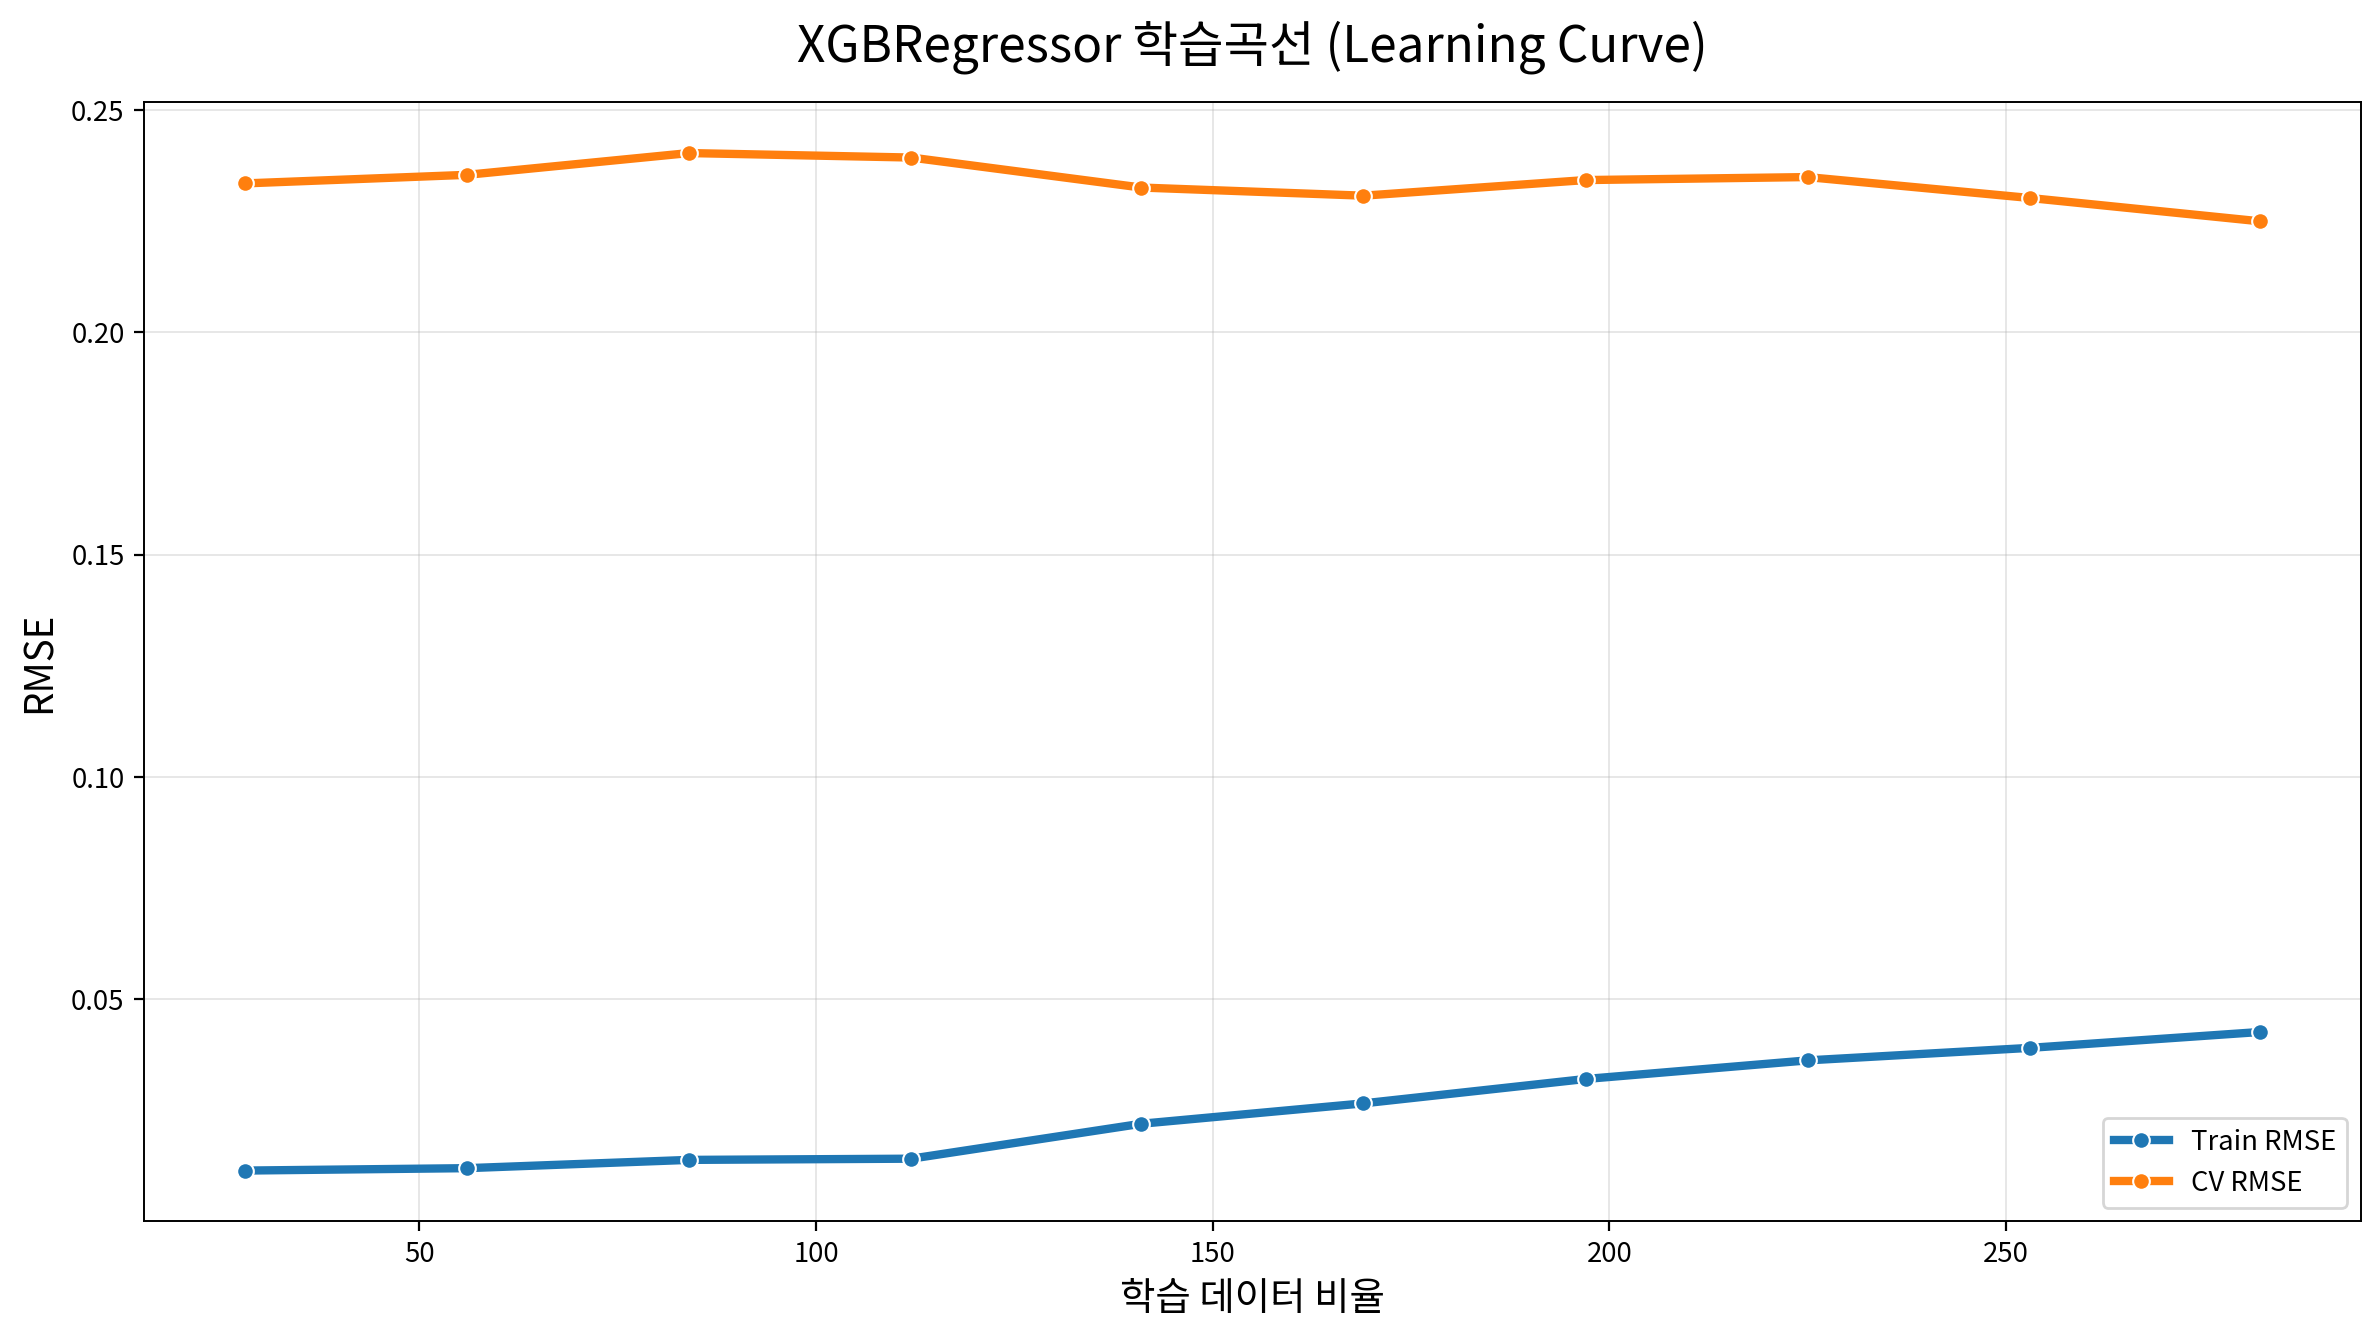

CPU times: total: 15.3 s
Wall time: 2min 47s


,결정계수(R2),평균절대오차(MAE),평균제곱오차(MSE),평균오차(RMSE),평균 절대 백분오차 비율(MAPE),평균 비율 오차(MPE),Train RMSE,CV RMSE 평균,CV RMSE 표준편차,Train/CV 비율,CV 변동성 비율,판정 결과
XGBRegressor,0.990,0.028,0.001,0.038,0.002,0.001,0.043,0.225,0.020,0.190,0.091,⚠️ 데이터 추가시 일반화 기대


In [3]:
%%time

xgb = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 52,
    n_jobs = 1,
    tree_method ='hist')
# 탐색할 하이퍼파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 5, 10]
    
    # poly 커널 확장용 (필요시 사용, 학습속도가 매우 느려짐)
    # 'model__kernel':['poly'],
    # 'model__degree':[2, 3, 4],
    # 'model__coef0':[0.0, 0.5, 1.0]
    }

# 그리드 서치 객체 생성
gs = GridSearchCV(estimator = xgb, param_grid = param_grid, cv=5, scoring ='r2', n_jobs = 11)

gs.fit(x_train, y_train)
best_model = gs.best_estimator_

hs_get_score_cv(best_model, x_train, y_train, x, y)

#### 인사이트

- 두 시스템간 결과에 차이가 나는 이유
    - 결정적 원인: GridSearchCV + n_jobs = -1 구조
    - 파라미터 조합 탐색 순서가 OS마다 다름
        - 병렬 fold 평가 순서가 다름
        - 동일 score 근처 후보 중 '먼저 끝난 모델'이 best로 선택됨
        - best_estimator 모델 자체가 서로 다름
        - max: 덜 과적화된 최적점 위주로 선택
        - windows: train에 과도하게 맞춘 최적점을 선택
- 두 플랫폼간 동일 결과를 얻기 위해서는 병렬성을 완전 제거해야 함
    - 모든 n_jobs 파라미터를 1로 설정해야 함
    - 하지만 실행결과가 너무 느리므로 굳이 둘 중 하나를 선택해야 한다면 성능이 아니라 CV 안정성 기준을 우선해야 하므로 mac 결과 쪽이 해석상 더 합리적

## 2. 변수 중요도(Feature Importance)
### 1. Feature Importance 추출

In [4]:
# sklearn-wrapper에서 학습된 컬럼명
feature_names = best_model.feature_names_in_
feature_names

AttributeError: `feature_names_in_` is defined only when `X` has feature names that are all strings.

In [ ]:
booster = best_model.get_booster()

# 성능기여도, 사용빈도, 영향범위
importance_types = ['gain','weight','cover']

raw_imp = {}

for itype in importance_types:
    raw_imp [itype] = booster.get_score(importance_type = itype)
raw_imp

{'gain': {'visitors': 0.02339032106101513,
  'avg_price': 0.040005043148994446,
  'marketing_cost': 0.06044062227010727,
  'delivery_ratio': 0.02323010191321373,
  'rain_mm': 0.048953671008348465,
  'temperature': 0.029000934213399887,
  'holiday': 0.6552891135215759,
  'weekend': 1.995676875114441},
 'weight': {'visitors': 475.0,
  'avg_price': 398.0,
  'marketing_cost': 331.0,
  'delivery_ratio': 242.0,
  'rain_mm': 316.0,
  'temperature': 300.0,
  'holiday': 43.0,
  'weekend': 24.0},
 'cover': {'visitors': 23.52842140197754,
  'avg_price': 33.273868560791016,
  'marketing_cost': 37.78852081298828,
  'delivery_ratio': 33.388431549072266,
  'rain_mm': 44.31012725830078,
  'temperature': 41.74333190917969,
  'holiday': 79.65116119384766,
  'weekend': 115.875}}

### 2. 모든 feature 집합

In [ ]:
imp_dict = raw_imp.copy()
features = set()
for d in imp_dict.values():
    features.update(d.keys())

features

{'avg_price',
 'delivery_ratio',
 'holiday',
 'marketing_cost',
 'rain_mm',
 'temperature',
 'visitors',
 'weekend'}

### 3. 모든 feature 이름을 인덱스로 갖는 빈 데이터프레임

In [ ]:
imp_df = DataFrame({'feature': sorted(features)})
imp_df.set_index('feature', inplace = True)
imp_df

""
feature
avg_price
delivery_ratio
holiday
marketing_cost
rain_mm
temperature
visitors
weekend


### 4. 각 스코어를 컬럼으로 추가

In [ ]:
for itype, d in imp_dict.items():
    imp_df[itype] = Series(d)

imp_df = imp_df.fillna(0)
imp_df

,gain,weight,cover
feature,,,
avg_price,0.040,398.000,33.274
delivery_ratio,0.023,242.000,33.388
holiday,0.655,43.000,79.651
marketing_cost,0.060,331.000,37.789
rain_mm,0.049,316.000,44.310
temperature,0.029,300.000,41.743
visitors,0.023,475.000,23.528
weekend,1.996,24.000,115.875


### 5. 비율 계산

In [ ]:
# 정규화 (비율)
for col in imp_df.columns:
    s = imp_df[col].sum()
    if s > 0:
        imp_df[col + '_ratio'] = imp_df[col] / s

# gain 기준 정렬

imp_df = imp_df.sort_values('gain', ascending = False)
imp_df

,gain,weight,cover,gain_ratio,weight_ratio,cover_ratio
feature,,,,,,
weekend,1.996,24.000,115.875,0.694,0.011,0.283
holiday,0.655,43.000,79.651,0.228,0.020,0.194
marketing_cost,0.060,331.000,37.789,0.021,0.155,0.092
rain_mm,0.049,316.000,44.310,0.017,0.148,0.108
avg_price,0.040,398.000,33.274,0.014,0.187,0.081
temperature,0.029,300.000,41.743,0.010,0.141,0.102
visitors,0.023,475.000,23.528,0.008,0.223,0.057
delivery_ratio,0.023,242.000,33.388,0.008,0.114,0.082


### 6. 누적합 컬럼 추가

In [ ]:
# 누적합
imp_df['gain_cumsum'] = imp_df['gain_ratio'].cumsum()
imp_df

,gain,weight,cover,gain_ratio,weight_ratio,cover_ratio,gain_cumsum
feature,,,,,,,
weekend,1.996,24.000,115.875,0.694,0.011,0.283,0.694
holiday,0.655,43.000,79.651,0.228,0.020,0.194,0.922
marketing_cost,0.060,331.000,37.789,0.021,0.155,0.092,0.943
rain_mm,0.049,316.000,44.310,0.017,0.148,0.108,0.960
avg_price,0.040,398.000,33.274,0.014,0.187,0.081,0.974
temperature,0.029,300.000,41.743,0.010,0.141,0.102,0.984
visitors,0.023,475.000,23.528,0.008,0.223,0.057,0.992
delivery_ratio,0.023,242.000,33.388,0.008,0.114,0.082,1.000


### 7. 변수 중요도 시각화

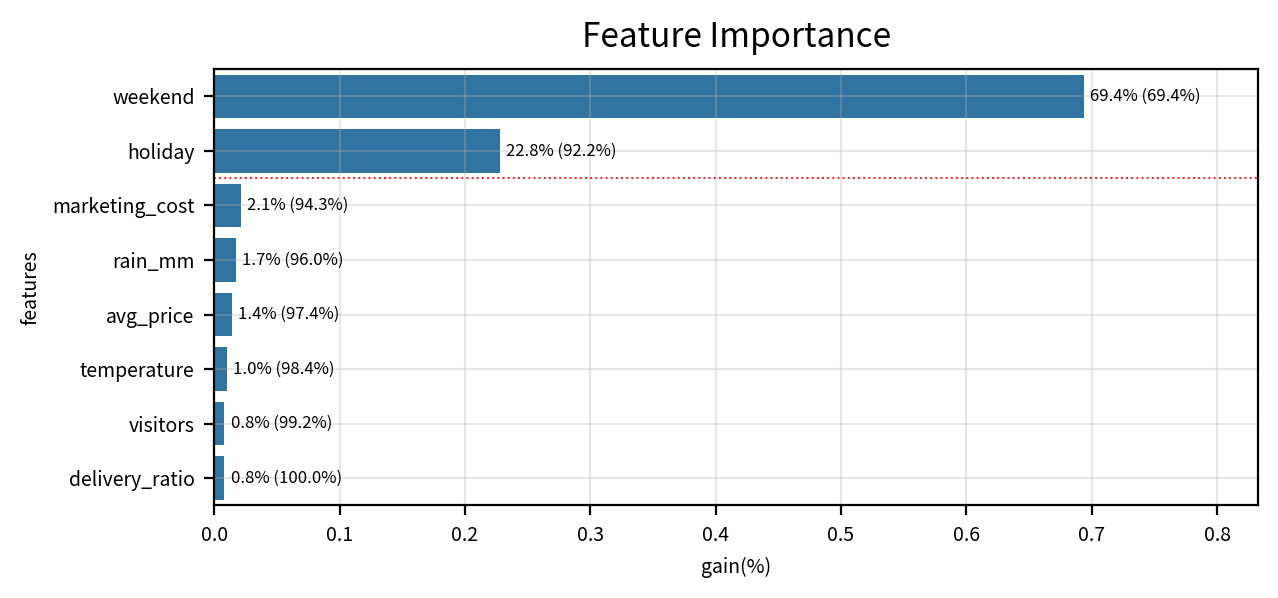

In [ ]:
figsize = (1280/my_dpi, 600/my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.barplot(data=imp_df, x='gain_ratio', y=imp_df.index, orient ='h')

# 값 라벨 추가
for i, v in enumerate(imp_df['gain_ratio']):
    ax.text(
        v + 0.005,                                                  # 막대 끝에서 약간 오른쪽
        i,                                                          # y 위치
        f'{v*100:.1f}% ({imp_df.iloc[i]['gain_cumsum']*100:.1f}%)', # 표시 형식
        va='center',
        fontsize=6         
    )

ax.set_title('Feature Importance', fontsize=12, pad=8)
ax.set_xlabel('gain(%)')
ax.set_ylabel('features')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, imp_df['gain_ratio'].max()*1.2)

threshold =0.9

# 90% 처음 도달하는 인덱스 (0-based)
cut_idx = np.argmax(imp_df['gain_cumsum'].values >= threshold)

# x축은 rank 기준이므로 +1
cut_rank = (int(cut_idx) + 1) - 0.5

# 90% 도달 지점 수직선 (핵심)
plt.axhline(
    y=cut_rank,
    linestyle=':',
    color='red',
    alpha=0.9,
    linewidth=0.7
)
plt.tight_layout()
plt.show()
plt.close()